# TUTORIAL: Train and export AI model to ONNX for optimized inference with Triton Inference Server

*A guide to export trained models to ONNX format.*

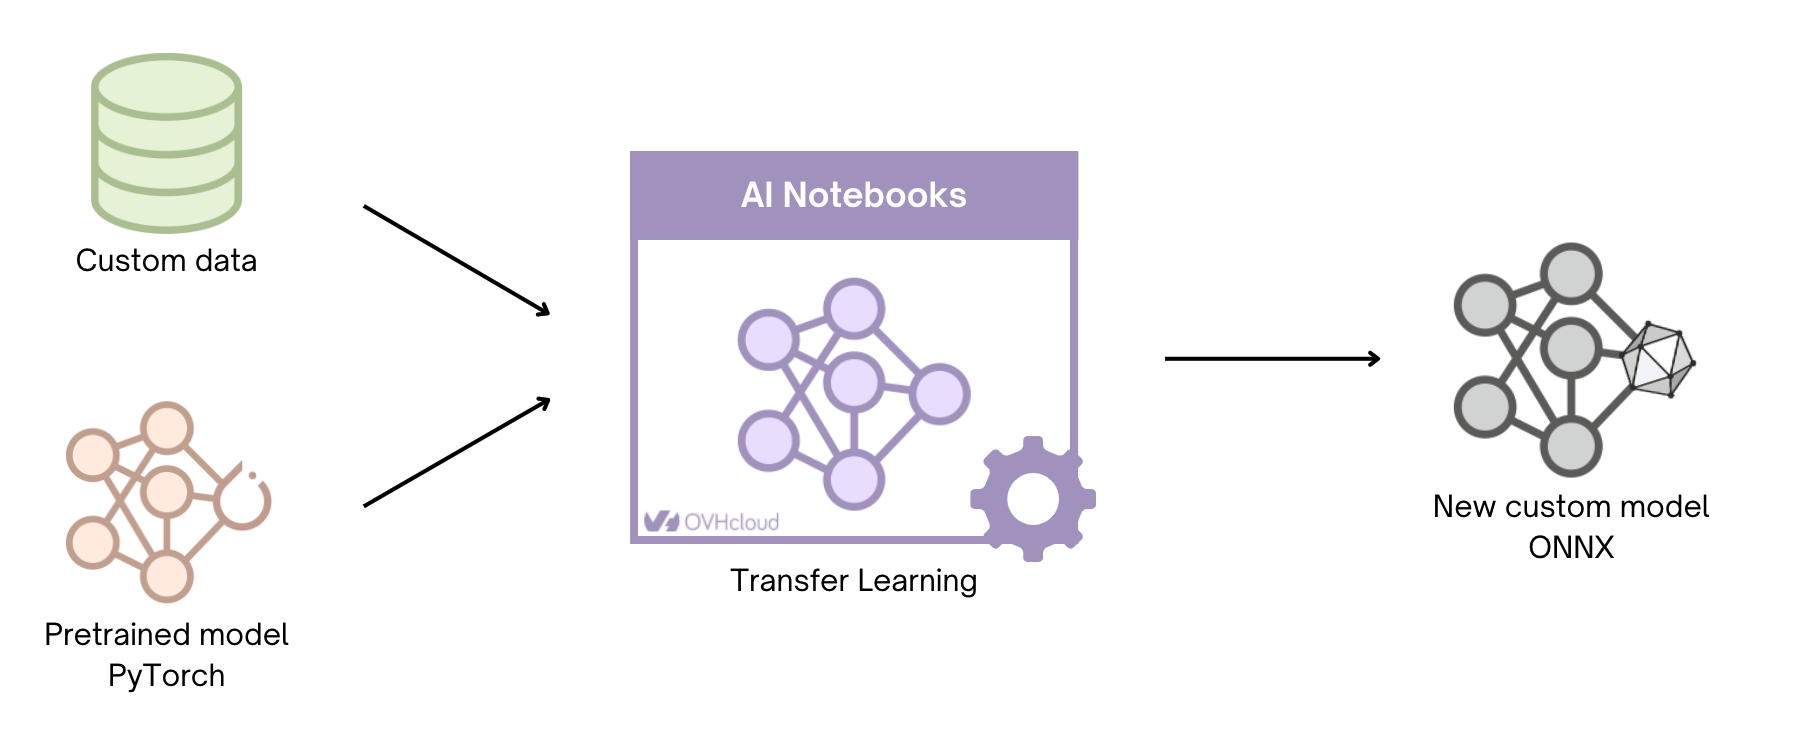

## Introduction

The purpose of this tutorial is to provide a guide on how to **export an AI model to ONNX** to be deployed for inference in optimized runtime environments such as **Triton Inference Server**.

For this purpose, a **Convolutional Neural Network** is used: **DenseNet**. The task is to transfer the learning from a **DenseNet121**, trained on **Imagenet** dataset, to a model that classifies various images.

## Definitions

### Transfer Learning

For both humans and machines, learning something new takes time and practice. However, it is easier to perform similar tasks to those already learned.
As with humans, AI will be able to identify patterns from previous knowledge and apply them to new learning.

If a model is trained on a database, there is no need to re-train the model from scratch to fit a new set of similar data. 

Main advantages of **Transfer Learning**:
- saving resources 
- improving efficiency 
- model training facilitation
- saving time

### DenseNet

[DenseNet](https://paperswithcode.com/method/densenet) models are **Densely Connected Convolutional Networks**. This type of convolutional neural networks uses dense connections between layers, where the layers are all connected.

**DenseNet121** is trained on more than a million images from the [ImageNet database](https://www.image-net.org/).

## Dataset

To show how Transfer Learning can be useful, **DenseNet121** will be trained on a custom dataset. 

#### **USE CASE:** CIFAR-10 dataset

To classify several images from daily life, the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset will be used

The dataset contains **10 classes**: 

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

## Code

To train DenseNet on custom dataset and export your new model to ONNX, follow the next steps.

### Step 1 - Librairies installation and import

In [ ]:
!pip install torch torchvision onnx matplotlib

In [1]:
# import dependencies
import os
import matplotlib.pyplot as plt

# import torch and torchvision for model loading and training
import torch
import torchvision
from torchvision import datasets, transforms, models

### Step 2 - Check GPU availability

> *Use a minimum of 1 GPU for proper performance.*

In [2]:
# check if cuda is available
def CheckGPU():
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print('Running on GPU')
        
    else:
        device = torch.device('cpu')
        print('Running on CPU')
        
    return device

In [3]:
# extract device info
device = CheckGPU()

Running on GPU


### Step 3 - Initialize DenseNet model

Load **DenseNet121 model** and its pretrained weights based on **ImageNet dataset**.

In [4]:
# initialize the model for this run
def InitializeModel(num_classes):
    
    # DenseNet weights based on imagenet
    densenet_model = models.densenet121(weights="IMAGENET1K_V1")
    num_ftrs = densenet_model.classifier.in_features
    densenet_model.classifier = torch.nn.Linear(num_ftrs, num_classes)
    
    # image size as inputs
    input_size = 224
    
    return densenet_model.to(device), input_size

In [5]:
# initialize DenseNet for cifar-10 images classification - 10 classes
densenet_model, input_size = InitializeModel(num_classes=10)

### Step 4 - Load and process your data

First of all, you can load your dataset with torchvision and normalize your `training` and `validation` sets. You can also apply some data augmentation on training data.

In [6]:
# train loader
train_loader = torch.utils.data.DataLoader(
datasets.CIFAR10('/workspace/data', train=True, download=True,
               transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ])),
    batch_size=32, shuffle=True)

# test loader
val_loader = torch.utils.data.DataLoader(
datasets.CIFAR10('/workspace/data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ])),
batch_size=32, shuffle=True)

Files already downloaded and verified


### Step 5 - Define the Training and Validation functions

Define the `TrainModel` function:

In [7]:
# define model training function
def TrainModel(epoch, model, train_loader, optimizer, loss_function):
    
    # launch model DenseNet training
    model.train()
    
    # set up variables
    running_loss=0
    correct=0
    total=0
    
    # train the model on training data
    for data in train_loader:

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step() 
        
        running_loss += loss.item()
     
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # calculate loss and accuracy on training set
    train_loss = running_loss/len(train_loader)
    accu = 100.*correct/total
    
    # add loss and accuracy into dedicated list
    train_losses.append(train_loss)
    train_accu.append(accu)
    # print result for each epoch
    print('Training - Loss: %.3f | Accuracy: %.3f'%(train_loss, accu))

    return

Define the `ValModel` function:

In [8]:
# define model validation function
def ValModel(epoch, model, val_loader, loss_function):
    
    # launch model DenseNet evaluation
    model.eval()
 
    running_loss=0
    correct=0
    total=0
    
    # evaluate the model on validation data
    with torch.no_grad():
        
        for data in val_loader:
            
            images,labels=data[0].to(device), data[1].to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            running_loss+=loss.item()
       
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # calculate loss and accuracy on validation set
    val_loss = running_loss/len(val_loader)
    accu = 100.*correct/total
    
    # add loss and accuracy into dedicated list
    eval_losses.append(val_loss)
    eval_accu.append(accu)
    
    # print result for each epoch
    print('Validation - Loss: %.3f | Accuracy: %.3f'%(val_loss,accu)) 

    return

### Step 6 - Fine-Tune DenseNet

Set up the following parameters:
- a **Loss Function** in order to calculate the training and validation losses of the model
- an **Optimizer** to optimize all the parameters
- a **Scheduler**

In [9]:
# set up loss function, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_model.parameters(), lr=0.01)

Launch the model **Training** and **Validation**:

In [10]:
# define the empty lists to add losses and accuracies
train_losses, train_accu, eval_losses, eval_accu = ([] for i in range(4))

# define the number of epochs
nmb_epochs = 20

# launch model training and evaluation
for epoch in range(nmb_epochs):

    print('\nEpoch %d/%d:'%(epoch, nmb_epochs-1))
    
    TrainModel(epoch, densenet_model, train_loader, optimizer, criterion)
    ValModel(epoch, densenet_model, val_loader, criterion)


Epoch 0/19:
Training - Loss: 2.016 | Accuracy: 31.848
Validation - Loss: 1.601 | Accuracy: 42.310

Epoch 1/19:
Training - Loss: 1.412 | Accuracy: 48.390
Validation - Loss: 1.255 | Accuracy: 54.930

Epoch 2/19:
Training - Loss: 1.208 | Accuracy: 56.698
Validation - Loss: 1.136 | Accuracy: 59.300

Epoch 3/19:
Training - Loss: 1.079 | Accuracy: 61.814
Validation - Loss: 1.052 | Accuracy: 62.590

Epoch 4/19:
Training - Loss: 0.979 | Accuracy: 65.460
Validation - Loss: 1.032 | Accuracy: 64.300

Epoch 5/19:
Training - Loss: 0.898 | Accuracy: 68.222
Validation - Loss: 0.909 | Accuracy: 68.260

Epoch 6/19:
Training - Loss: 0.834 | Accuracy: 70.562
Validation - Loss: 0.828 | Accuracy: 71.300

Epoch 7/19:
Training - Loss: 0.777 | Accuracy: 72.708
Validation - Loss: 0.809 | Accuracy: 72.210

Epoch 8/19:
Training - Loss: 0.722 | Accuracy: 74.926
Validation - Loss: 0.871 | Accuracy: 70.770

Epoch 9/19:
Training - Loss: 0.678 | Accuracy: 76.396
Validation - Loss: 0.722 | Accuracy: 75.030

Epoch 10/

### Step 7 - Display training and validation results

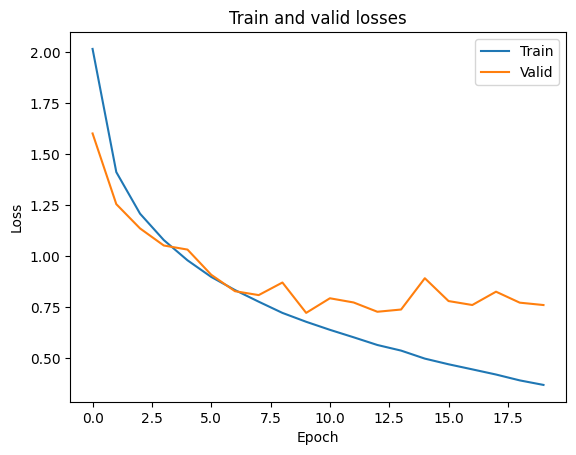

In [11]:
# display model loss on training and validation data
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train and valid losses')
 
plt.show()

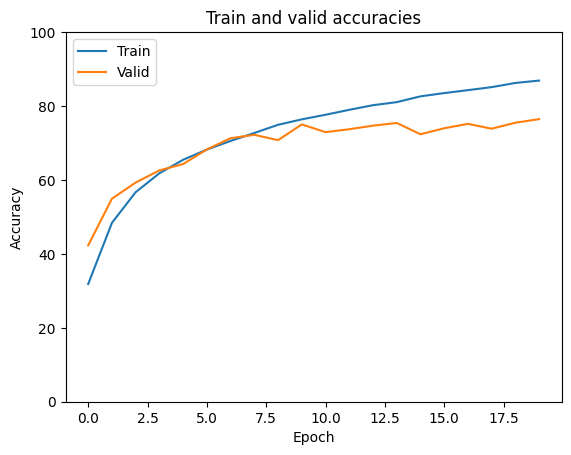

In [12]:
# display model accuracy on training and validation data
plt.plot(train_accu)
plt.plot(eval_accu)
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train and valid accuracies')
 
plt.show()

### Step 8 - Save PyTorch model

In [13]:
# set up the path to your PTH model as an environment variable
os.environ['MODEL_PATH'] = '/workspace/densenet_cifar10.pth'

In [14]:
# save pytorch model
torch.save(densenet_model.state_dict(), os.environ.get('MODEL_PATH'))

In [15]:
densenet_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Step 9 - Export ONNX model for inference

Convert your PyTorch model to ONNX.

In [16]:
# Load the weights from a file (.pth usually)
state_dict = torch.load(os.environ.get('MODEL_PATH'))

# Load the weights now into a model net architecture defined by our class
densenet_model.load_state_dict(state_dict)

# Create the right input shape (e.g. for an image)
dummy_input = torch.randn(1, 3, 224, 224, device="cuda")

torch.onnx.export(densenet_model, dummy_input, "densenet_onnx_cifar10.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Create a model repository and download our example `densenet_onnx_cifar10` model into it.

In [17]:
!mkdir -p /workspace/models/densenet_onnx_cifar10/1

In [18]:
!cp /workspace/densenet_onnx_cifar10.onnx /workspace/models/densenet_onnx_cifar10/1

Create a model configuration for the `densenet_onnx_cifar10` model in the model repository at `/workspace/models/densenet_onnx_cifar10/config.pbtxt`.

Create the `config.pbtxt` file:

Finally, create the `densenet_labels.txt` file containing the classes names and add it into the model repository at `/workspace/models/densenet_onnx_cifar10/densenet_labels.txt`.

You should get the following `/models` directory architecture:

```
models/
├── densenet_onnx_cifar10
│   ├── 1
│   │   └── densenet_onnx_cifar10.onnx
│   ├── config.pbtxt
│   └── densenet_labels.txt
```